## Observations

Month is not a useful variable. Try Quarter.
Best result so far is decision tree with df[['Exterior Wall', 'Fixtures', 'Neighborhood', 'Story Height', 'Assessment Ratio', 'Building Grade', 'Quarter']]

Lots of outliers here, try RandomForest

With XGBoost, got down to 40.9

## Next step: incorporate data from full dataframe.

Possibly: average fixtures per house in the neighborhood?

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd 
%matplotlib inline
sns.set(style='darkgrid')
import matplotlib.dates as mdates

In [2]:
df1=pd.read_csv('nashville_20190813150235.csv', parse_dates = ['Most Recent Sale Date', 'Sale Date'], dtype={'Zone': str, 'Neighborhood': str})

C:\Users\alehe\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (39) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
#Creating new dataframe without duplicate entires
df=df1.sort_values(by='Sale Date').drop_duplicates(subset='Map & Parcel', keep = 'last')
#Dropping parcels that were involved in multi-parcel sales
#Want to create a new column which is the mean sale price per square foot of a parcel in that neighborhood
df['PPS']=df['Sale Price']/df['Square Footage Improved']
df['PPS']=df['PPS'].replace(np.inf, np.nan)
meanpps=df.groupby('Neighborhood')['PPS'].mean().to_frame().rename(columns={'PPS':'NeighborhoodPPS'})
df=df.merge(meanpps, how='left', left_on = 'Neighborhood',right_index=True)
df=df[df['Multiple Parcels Involved in Sale'] == 'No']
#Testing the averaged assessment ratio idea.
df['Assessment Ratio'] = df['Assessment Land Improved'] / df['Total Appraisal Value Improved']
nbhdratio=df.groupby('Neighborhood')['Assessment Ratio'].mean().to_frame().rename(columns={'Assessment Ratio':'Nbhd Ratio'})
df=df.merge(nbhdratio, how='left', left_on = 'Neighborhood',right_index=True)
df['Month']= df['Sale Date'].dt.month
df['Quarter'] = df['Sale Date'].dt.quarter
#df = df[(df.Neighborhood != '9527') & (df.Neighborhood != '9026')]

In [71]:
df['Building Grade']= df['Building Grade'].str.replace(r'\w\w\w', '').dropna()

In [58]:
df['PPS'].quantile([.9, .95, .995])

0.900    266.666667
0.950    315.803927
0.995    583.715271
Name: PPS, dtype: float64

In [60]:
df.nlargest(15, 'PPS')[['Location', 'Zone', 'Sale Price', 'PPS', 'Square Footage Improved']]

,Location,Zone,Sale Price,PPS,Square Footage Improved
190760,1221 OLD HICKORY BLVD,2,960000.0,1290.322581,744.0
77176,1701 RUSSELL ST,6,730000.0,1276.223776,572.0
75808,122 S 12TH ST,6,1135000.0,1266.741071,896.0
116428,2310 BELMONT BLVD,2,865000.0,1259.097525,687.0
118882,2037 ELLIOTT AVE,2,745000.0,1258.445946,592.0
279745,515 CHURCH ST Unit 4502,9,5500000.0,1257.142857,4375.0
73958,1020 MAXWELL AVE,6,685000.0,1254.578755,546.0
135423,1014 PARIS AVE,2,739000.0,1248.310811,592.0
75746,1408 WOODLAND ST,6,945000.0,1217.783505,776.0
107225,216 54TH AVE N,2,430000.0,1194.444444,360.0


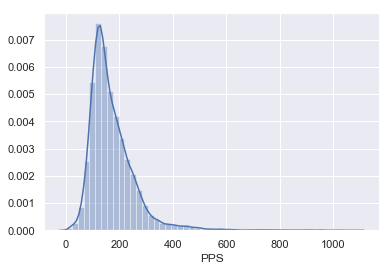

In [68]:
df=df[df.PPS <= 1200]
sns.distplot(df['PPS'].dropna())

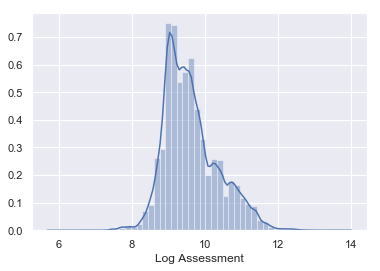

In [69]:
df['Log Assessment']= df['Assessment Land Improved'].map(lambda x: np.log(x) if (pd.notnull(x) and x != 0) else None)
df['Log Assessment']=df['Log Assessment'].replace(np.inf, np.nan)
sns.distplot(df['Log Assessment'].dropna())

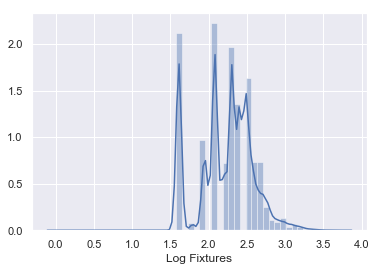

In [70]:
df['Log Fixtures']= df['Fixtures'].map(lambda x: np.log(x) if (pd.notnull(x) and x != 0) else None)
df['Log Fixtures']=df['Log Fixtures'].replace(np.inf, np.nan)
sns.distplot(df['Log Fixtures'].dropna())

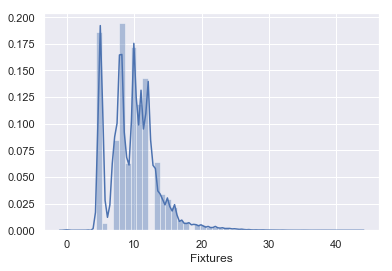

In [8]:
sns.distplot(df['Fixtures'].dropna())

In [9]:
np.std(df.PPS)

89.58656452443442

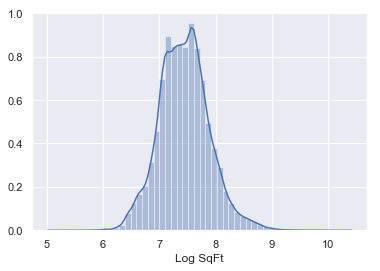

In [72]:
df['Log SqFt']= df['Square Footage Improved'].map(lambda x: np.log(x) if (pd.notnull(x) and x != 0) else None)
df['Log SqFt']=df['Log SqFt'].replace(np.inf, np.nan)
sns.distplot(df['Log SqFt'].dropna())

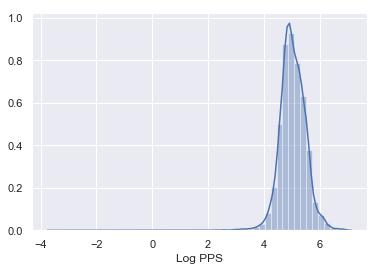

In [73]:
df['Log PPS']= df['PPS'].map(lambda x: np.log(x) if (pd.notnull(x) and x != 0) else None)
df['Log PPS']=df['Log PPS'].replace(np.inf, np.nan)
sns.distplot(df['Log PPS'].dropna())

In [12]:
from sklearn.metrics import mean_squared_error as MSE
from sklearn.tree import DecisionTreeRegressor as DTR
from sklearn.model_selection import train_test_split

In [74]:
df2 = df[['Exterior Wall','Building Grade','Log Fixtures', 'Log SqFt','Nbhd Ratio', 'NeighborhoodPPS', 'Log PPS', 'Log Assessment', 'Quarter']].dropna()
X= pd.get_dummies(df2[['Exterior Wall','Building Grade', 'NeighborhoodPPS','Log Fixtures','Nbhd Ratio','Log SqFt', 'Log Assessment', 'Quarter']])
y=df2['Log PPS']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.28, random_state=42)

In [50]:
df2.shape

(54138, 9)

In [75]:
from sklearn.dummy import DummyRegressor as DR
model = DR(strategy='median')
dr=model.fit(X_train, y_train)
y_pred= dr.predict(X_test)
print(MSE(np.exp(y_pred), np.exp(y_test))**0.5)

91.94129971841934


In [76]:
model = DTR()
dtr=model.fit(X_train, y_train)
y_pred= dtr.predict(X_test)
print(MSE(np.exp(y_pred), np.exp(y_test))**0.5)

55.03710201372207


In [29]:
np.exp(y_test).mean()

170.19746557132845

In [57]:
np.exp(y_test).median()

149.57812500000003

In [77]:
from sklearn.ensemble import RandomForestRegressor as RFR
model = RFR(random_state=42)
rfr=model.fit(X_train,y_train)
y_pred=rfr.predict(X_test)
print(MSE(np.exp(y_pred), np.exp(y_test))**0.5)

C:\Users\alehe\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


43.88741610455989


In [78]:
from xgboost import XGBRegressor as XGBR

model = XGBR(colsample_bytree=0.4, gamma=0, learning_rate=0.07, 
             max_depth=4, min_child_weight=1.5, n_estimators=2000,                                                                    
             reg_alpha=0.75, reg_lambda=0.45, subsample=0.6, seed=42)

xgbr=model.fit(X_train,y_train)
y_pred=xgbr.predict(X_test)
print(MSE(np.exp(y_pred), np.exp(y_test))**0.5)

41.87549400179334


In [ ]:
#Best score so far
colsample_bytree=0.4, gamma=0, learning_rate=0.07, 
             max_depth=5, min_child_weight=1.5, n_estimators=2000,                                                                    
             reg_alpha=0.75, reg_lambda=0.45, subsample=0.6, seed=42

In [ ]:
#Import SVR

### GridSearchCV didn't get as good results as untuned RandomForest.

In [16]:
# Number of trees in random forest
n_estimators = [100,150]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [6,7,8]
# Minimum number of samples required to split a node
min_samples_split = [2,3,4]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1,2,3]

random_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               }

In [ ]:
from sklearn.model_selection import GridSearchCV
rfgrid = GridSearchCV(estimator = model, param_grid = random_grid, cv = 3, verbose=2, n_jobs = -1)
# Fit the random search model
rf_r = rfgrid.fit(X_train, y_train)

Fitting 3 folds for each of 54 candidates, totalling 162 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 11.4min


In [ ]:
rfgrid.best_params_

In [ ]:
rfgrid.best_score_ 

In [ ]:
np.exp(rfgrid.best_score_ )